CartPoleを利用した簡単な環境

In [10]:
import gymnasium as gym
from stable_baselines3 import PPO

# 環境を作成
env = gym.make('CartPole-v1')

# PPOモデルを作成
model = PPO("MlpPolicy", env, verbose=1)

# モデルの訓練
model.learn(total_timesteps=10000)
# テスト環境をリセット
obs, info = env.reset()

# エージェントを動作させる
for _ in range(1000):
    action, _states = model.predict(obs)
    obs, reward, terminated, truncated, info = env.step(action)
    env.render()
    if terminated or truncated:
        obs, info = env.reset()

env.close()

# モデルの保存
model.save("ppo_cartpole")

# モデルのロード
model = PPO.load("ppo_cartpole")

from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
import torch.nn as nn
import torch

class CustomMLP(BaseFeaturesExtractor):
    def __init__(self, observation_space, features_dim=128):
        # observation_space.shape[0]で観測データの次元数を取得
        super(CustomMLP, self).__init__(observation_space, features_dim)
        # 全結合層を定義
        self.net = nn.Sequential(
            nn.Linear(observation_space.shape[0], 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, features_dim),  # 最終的に128次元に変換
            nn.ReLU(),
        )

    def forward(self, observations):
        # 観測データを全結合ネットワークに通す
        return self.net(observations)

# カスタムポリシーを使用してモデルを作成
policy_kwargs = dict(
    features_extractor_class=CustomMLP,
    features_extractor_kwargs=dict(features_dim=128),
)

model = PPO("MlpPolicy", env, policy_kwargs=policy_kwargs, verbose=1)
model.learn(total_timesteps=10000)


c:\Users\sugiy\anaconda3\envs\baseline3\lib\site-packages\gymnasium\envs\classic_control\cartpole.py:215: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(


独自の１次元のゴールを目指す探索ゲームの環境を作成してプレイ

In [18]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class Simple1DEnv(gym.Env):
    def __init__(self):
        super(Simple1DEnv, self).__init__()
        # 1Dの観測空間 (-10から10の位置)
        self.observation_space = spaces.Box(low=np.array([-10]), high=np.array([10]), dtype=np.float32)
        
        # 0: 左, 1: 右に移動する行動空間
        self.action_space = spaces.Discrete(2)
        
        # エージェントの初期位置を定義
        self.state = None
        self.goal_position = 8  # ゴールの位置を設定
        self.reset()

    def reset(self, seed=None, options=None):
        # seedが指定されていた場合、それを使って乱数生成器をリセット
        super().reset(seed=seed)
        
        # エージェントの初期位置をランダムに決定（範囲内）
        self.state = np.array([np.random.uniform(-10, 10)], dtype=np.float32)
        return self.state, {}

    def step(self, action):
        # 左へ移動
        if action == 0:
            self.state[0] -= 1
        # 右へ移動
        elif action == 1:
            self.state[0] += 1

        # 状態が観測範囲を超えないようにクリップ
        self.state = np.clip(self.state, self.observation_space.low, self.observation_space.high)
        
        # 報酬と終了条件を設定
        done = bool(self.state[0] == self.goal_position)
        reward = 1 if done else -0.1  # ゴールに到達したら報酬1、通常はペナルティ-0.1

        return self.state, reward, done, False, {}

    def render(self, mode='human'):
        # 現在の位置を出力
        print(f"Agent's Position: {self.state[0]}")



In [33]:
import gymnasium as gym
from gymnasium.envs.registration import register

# 環境を登録
register(
    id='Simple1DEnv-v0',  # 環境のID
    entry_point='__main__:Simple1DEnv',  # 環境クラスへのパス
)

# 環境の作成
env = gym.make('Simple1DEnv-v0')


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 166      |
|    ep_rew_mean     | -15.5    |
| time/              |          |
|    fps             | 338      |
|    iterations      | 1        |
|    time_elapsed    | 6        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 83.4       |
|    ep_rew_mean          | -7.24      |
| time/                   |            |
|    fps                  | 312        |
|    iterations           | 2          |
|    time_elapsed         | 13         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01717596 |
|    clip_fraction        | 0.171      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.6

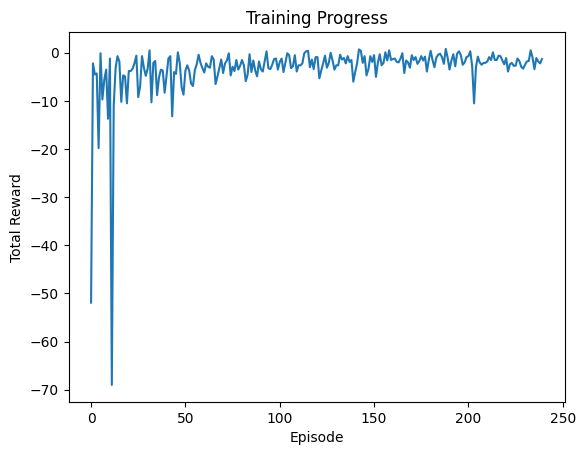

In [34]:
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt

# 累積報酬を記録するためのコールバック
class RewardCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardCallback, self).__init__(verbose)
        self.episode_rewards = []

    def _on_step(self) -> bool:
        # エピソードが終了したときに報酬を記録
        if self.locals["dones"][0]:
            episode_reward = self.locals["infos"][0]["episode"]["r"]  # 報酬はfloatなので直接取得
            self.episode_rewards.append(episode_reward)
        return True



# PPOモデルを作成
model = PPO("MlpPolicy", env, verbose=1)

# コールバックを定義
reward_callback = RewardCallback()

# 学習中に報酬を記録しながら10,000ステップ学習
model.learn(total_timesteps=10000, callback=reward_callback)

# 学習後の報酬の推移をプロット
plt.plot(reward_callback.episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Progress')
plt.show()


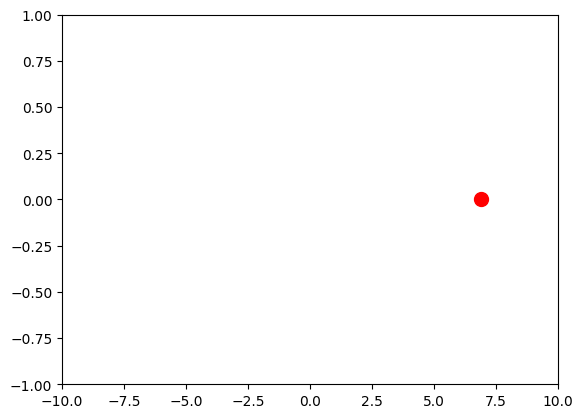

In [24]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML

# アニメーション用の描画設定
fig, ax = plt.subplots()
ax.set_xlim(-10, 10)  # ここは環境に応じて調整
ax.set_ylim(-1, 1)    # Y軸の範囲も調整
agent, = ax.plot([], [], 'ro', markersize=10)  # エージェントの位置を表示

# 初期化関数
def init():
    agent.set_data([], [])
    return agent,

# フレームごとの更新関数
def update(frame):
    global obs
    action, _states = model.predict(obs)
    obs, reward, terminated, truncated, info = env.step(action)
    
    # エージェントの位置を更新 (xの値はリストに変換)
    agent.set_data([obs[0]], [0])
    
    if terminated or truncated:
        obs, info = env.reset()
    
    return agent,

# アニメーションを作成
ani = animation.FuncAnimation(fig, update, frames=100, init_func=init, blit=True)

# アニメーションを表示
HTML(ani.to_jshtml())
